<a href="https://colab.research.google.com/github/antdawg925/Cocolab/blob/main/imageSpotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow_datasets.core import SplitGenerator
from tensorflow_datasets.video.bair_robot_pushing import BairRobotPushingSmall

import tempfile
import pathlib

TEST_DIR = pathlib.Path(tempfile.mkdtemp()) / "bair_robot_pushing_small/softmotion30_44k/test/"

In [5]:
# Download the test split to $TEST_DIR
%cd /Users/antea/Documents/my_projects/
!mkdir -p $TEST_DIR
!wget -nv https://storage.googleapis.com/download.tensorflow.org/data/bair_test_traj_0_to_255.tfrecords -O $TEST_DIR/traj_0_to_255.tfrecords

[Errno 2] No such file or directory: '/Users/antea/Documents/my_projects/'
/content
2022-07-11 00:56:42 URL:https://storage.googleapis.com/download.tensorflow.org/data/bair_test_traj_0_to_255.tfrecords [189852160/189852160] -> "/tmp/tmph_bzh1_g/bair_robot_pushing_small/softmotion30_44k/test/traj_0_to_255.tfrecords" [1]


In [ ]:
# Since the dataset builder expects the train and test split to be downloaded,
# patch it so it only expects the test data to be available
builder = BairRobotPushingSmall()
test_generator = SplitGenerator(name='test', gen_kwargs={"filedir": str(TEST_DIR)})
builder._split_generators = lambda _: [test_generator]
builder.download_and_prepare()

In [ ]:
# @title Load some example data (BAIR).
batch_size = 16

# If unable to download the dataset automatically due to "not enough disk space", please download manually to Google Drive and
# load using tf.data.TFRecordDataset.
ds = builder.as_dataset(split="test")
test_videos = ds.batch(batch_size)
first_batch = next(iter(test_videos))
input_frames = first_batch['image_aux1'][:, ::15]
input_frames = tf.cast(input_frames, tf.float32)

Test videos shape [batch_size, start/end frame, height, width, num_channels]:  (16, 2, 64, 64, 3)


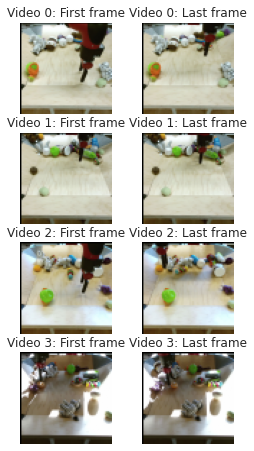

In [8]:
# @title Visualize loaded videos start and end frames.

print('Test videos shape [batch_size, start/end frame, height, width, num_channels]: ', input_frames.shape)
sns.set_style('white')
plt.figure(figsize=(4, 2*batch_size))

for i in range(batch_size)[:4]:
  plt.subplot(batch_size, 2, 1 + 2*i)
  plt.imshow(input_frames[i, 0] / 255.0)
  plt.title('Video {}: First frame'.format(i))
  plt.axis('off')
  plt.subplot(batch_size, 2, 2 + 2*i)
  plt.imshow(input_frames[i, 1] / 255.0)
  plt.title('Video {}: Last frame'.format(i))
  plt.axis('off')

In [ ]:
hub_handle = 'https://tfhub.dev/google/tweening_conv3d_bair/1'
module = hub.load(hub_handle).signatures['default']

In [10]:
filled_frames = module(input_frames)['default'] / 255.0

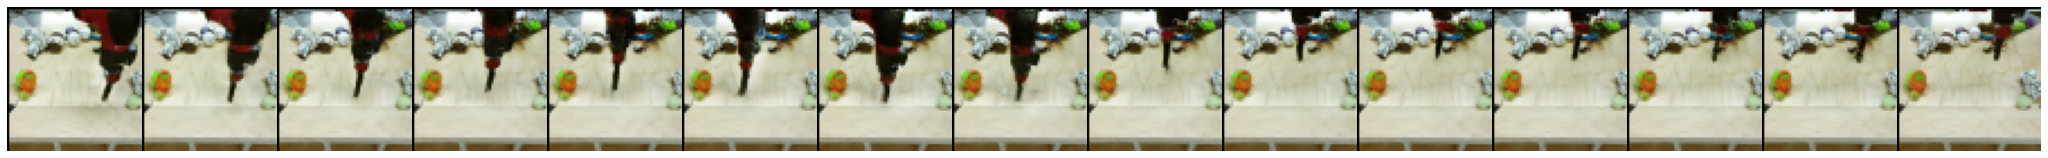

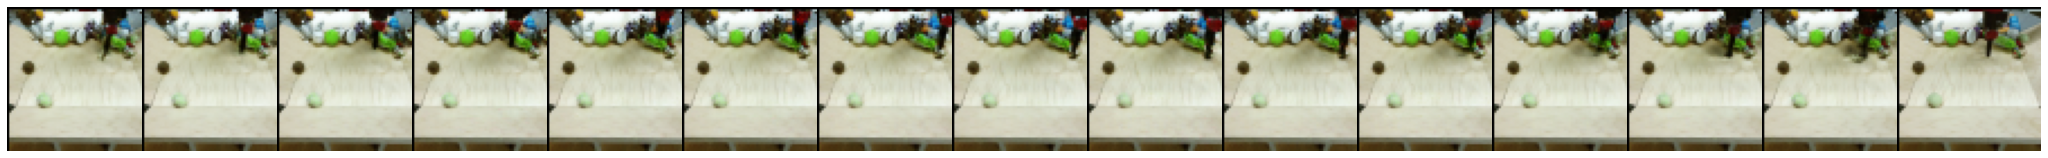

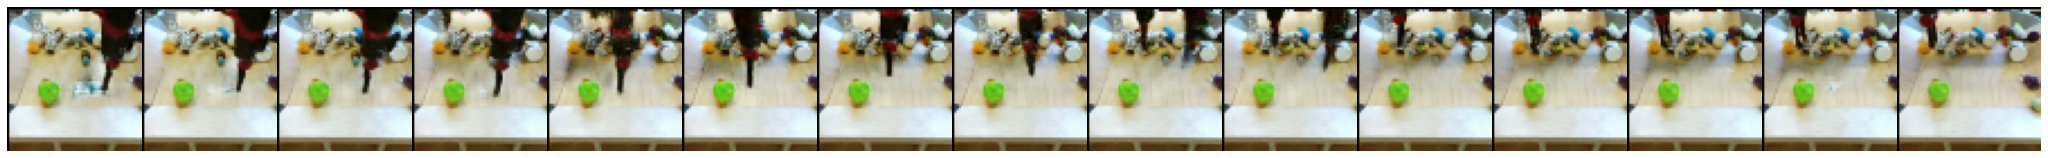

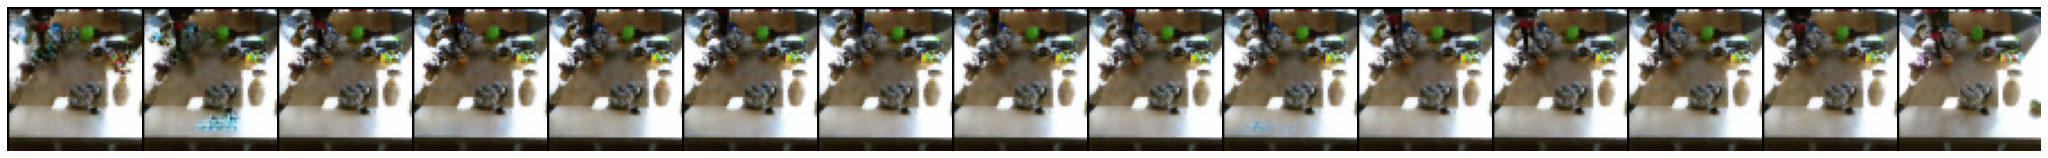

In [11]:
# Show sequences of generated video frames.

# Concatenate start/end frames and the generated filled frames for the new videos.
generated_videos = np.concatenate([input_frames[:, :1] / 255.0, filled_frames, input_frames[:, 1:] / 255.0], axis=1)

for video_id in range(4):
  fig = plt.figure(figsize=(10 * 2, 2))
  for frame_id in range(1, 16):
    ax = fig.add_axes([frame_id * 1 / 16., 0, (frame_id + 1) * 1 / 16., 1],
                      xmargin=0, ymargin=0)
    ax.imshow(generated_videos[video_id, frame_id])
    ax.axis('off')